In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import shap
from tqdm.notebook import tqdm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load financial time series data from a CSV file
data = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')
data['Date'] = pd.to_datetime(data['Date'])
#data.set_index('Date', inplace=True)

In [3]:
data

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL
...,...,...,...,...,...,...,...
3014,2017-12-22,174.68,175.42,174.50,175.01,16349444,AAPL
3015,2017-12-26,170.80,171.47,169.68,170.57,33185536,AAPL
3016,2017-12-27,170.10,170.78,169.71,170.60,21498213,AAPL
3017,2017-12-28,171.00,171.85,170.48,171.08,16480187,AAPL


In [4]:
# Prepare the dataset
prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

In [5]:
# Split the data into train and test sets
train_size = int(len(scaled_prices) * 0.8)
train_data, test_data = scaled_prices[:train_size], scaled_prices[train_size:]

In [6]:
# Create sequences for input and output
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append((seq, target))
    return sequences

In [7]:
seq_length = 100
train_sequences = create_sequences(train_data, seq_length)
test_sequences = create_sequences(test_data, seq_length)

In [8]:
X_train, y_train = np.array([seq for seq, target in train_sequences]), np.array([target for seq, target in train_sequences])
X_test, y_test = np.array([seq for seq, target in test_sequences]), np.array([target for seq, target in test_sequences])

In [9]:
X_train = X_train.reshape(-1, X_train.shape[1])
X_test = X_test.reshape(-1, X_test.shape[1])
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(y_test.shape)

(2315, 100)
[[0.02033337 0.0205107  0.02003783 ... 0.01052134 0.01069866 0.01152619]
 [0.0205107  0.02003783 0.02163376 ... 0.01069866 0.01152619 0.01087599]
 [0.02003783 0.02163376 0.02139733 ... 0.01152619 0.01087599 0.0089254 ]
 ...
 [0.68772905 0.69576782 0.70812153 ... 0.67419317 0.6572881  0.63482681]
 [0.69576782 0.70812153 0.71657406 ... 0.6572881  0.63482681 0.63931907]
 [0.70812153 0.71657406 0.71084052 ... 0.63482681 0.63931907 0.63772314]]
(504, 100)
(504, 1)


In [10]:
# Build and train an LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(1)
])

In [11]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
73/73 [==============================] - 2s 17ms/step - loss: 0.0209 - val_loss: 0.0107
Epoch 2/50
73/73 [==============================] - 1s 16ms/step - loss: 3.4244e-04 - val_loss: 7.4752e-04
Epoch 3/50
73/73 [==============================] - 1s 16ms/step - loss: 1.6969e-04 - val_loss: 4.2813e-04
Epoch 4/50
73/73 [==============================] - 1s 16ms/step - loss: 1.6761e-04 - val_loss: 6.5569e-04
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 1.5680e-04 - val_loss: 5.5949e-04
Epoch 6/50
73/73 [==============================] - 1s 16ms/step - loss: 1.4458e-04 - val_loss: 4.3022e-04
Epoch 7/50
73/73 [==============================] - 1s 16ms/step - loss: 1.3846e-04 - val_loss: 4.3935e-04
Epoch 8/50
73/73 [==============================] - 1s 16ms/step - loss: 1.4022e-04 - val_loss: 0.0011
Epoch 9/50
73/73 [==============================] - 1s 16ms/step - loss: 1.3702e-04 - val_loss: 6.9366e-04
Epoch 10/50
73/73 [==============================

In [12]:
# Make predictions
y_pred = model.predict(X_test)

16/16 [==============================] - 0s 4ms/step


In [13]:
# Inverse transform predictions to original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

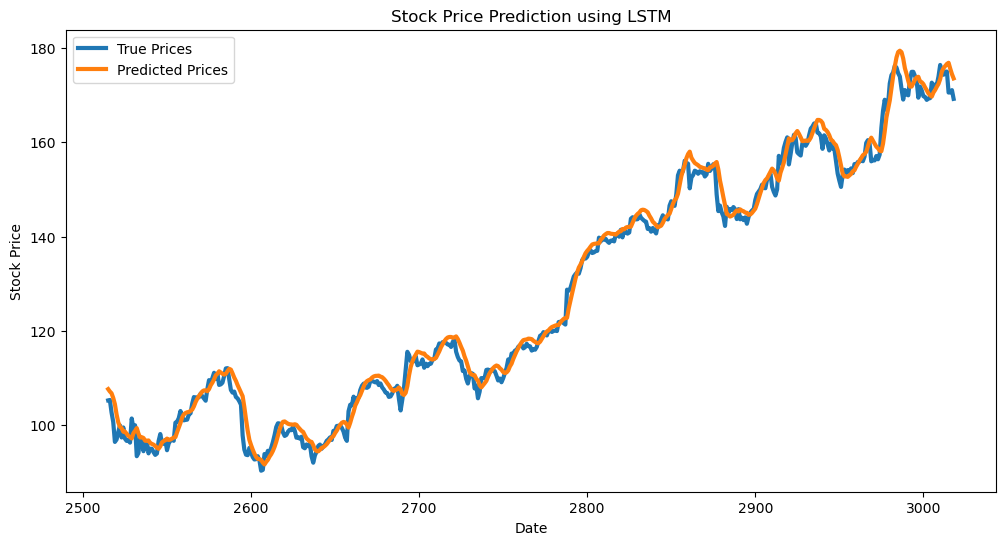

In [14]:
# Plot the predicted vs. actual stock prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size+seq_length:], y_test_original, label='True Prices', lw=3)
plt.plot(data.index[train_size+seq_length:], y_pred_original, label='Predicted Prices', lw=3)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.legend()
plt.show()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
import shap
import time
import tensorflow as tf

shap.initjs()

In [17]:
X_test
X_train

array([[0.02033337, 0.0205107 , 0.02003783, ..., 0.01052134, 0.01069866,
        0.01152619],
       [0.0205107 , 0.02003783, 0.02163376, ..., 0.01069866, 0.01152619,
        0.01087599],
       [0.02003783, 0.02163376, 0.02139733, ..., 0.01152619, 0.01087599,
        0.0089254 ],
       ...,
       [0.68772905, 0.69576782, 0.70812153, ..., 0.67419317, 0.6572881 ,
        0.63482681],
       [0.69576782, 0.70812153, 0.71657406, ..., 0.6572881 , 0.63482681,
        0.63931907],
       [0.70812153, 0.71657406, 0.71084052, ..., 0.63482681, 0.63931907,
        0.63772314]])

### shap value take only same dimension

In [18]:
shap.initjs()

In [19]:
explainer = shap.Explainer(model.predict, X_train[:20])

In [20]:
print(explainer)

shap.explainers.Permutation()


In [21]:
shap_values = explainer.shap_values(X_test[:20])

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  20%|█████▊                       | 4/20 [00:00<?, ?it/s]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  30%|██████▎              | 6/20 [00:13<00:17,  1.25s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  35%|███████▎             | 7/20 [00:15<00:22,  1.77s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  40%|████████▍            | 8/20 [00:18<00:24,  2.04s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  45%|█████████▍           | 9/20 [00:20<00:24,  2.19s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  50%|██████████          | 10/20 [00:23<00:22,  2.29s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  55%|███████████         | 11/20 [00:25<00:21,  2.35s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  60%|████████████        | 12/20 [00:28<00:19,  2.40s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  65%|█████████████       | 13/20 [00:30<00:16,  2.42s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  70%|██████████████      | 14/20 [00:33<00:14,  2.44s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  75%|███████████████     | 15/20 [00:35<00:12,  2.46s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  80%|████████████████    | 16/20 [00:38<00:09,  2.47s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  85%|█████████████████   | 17/20 [00:40<00:07,  2.47s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  90%|██████████████████  | 18/20 [00:43<00:04,  2.48s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer:  95%|███████████████████ | 19/20 [00:45<00:02,  2.48s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer: 100%|████████████████████| 20/20 [00:48<00:00,  2.49s/it]

64/64 [==============================] - 0s 4ms/step


Permutation explainer: 21it [00:50,  2.99s/it]                                  


In [30]:
shap_values.shape


(20, 100)

In [31]:
X_test.shape

(504, 100)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


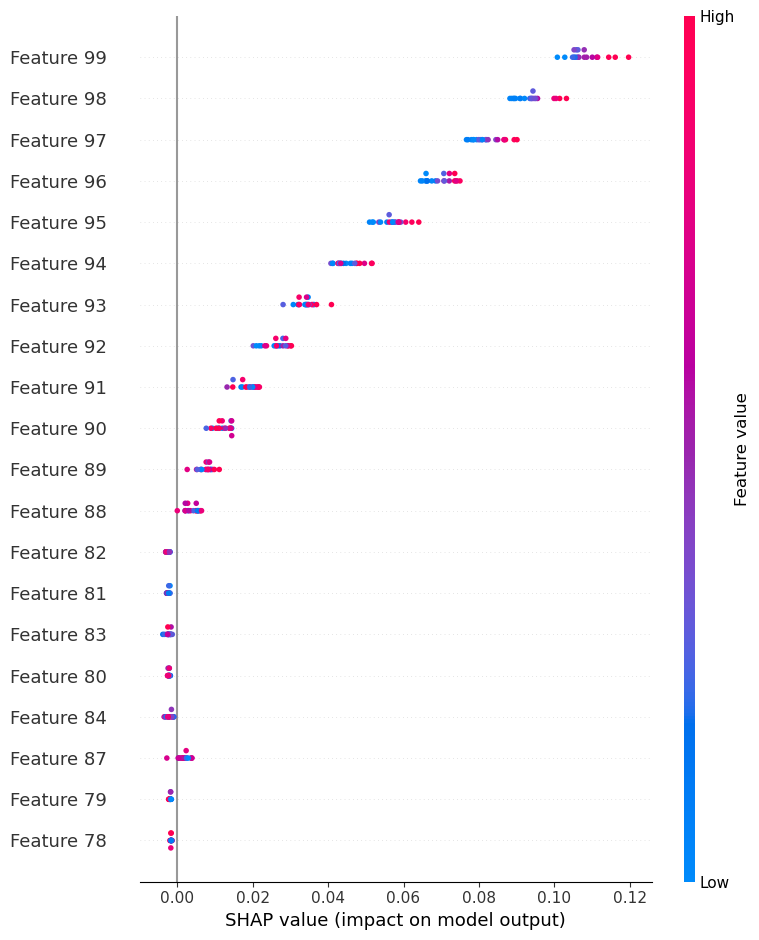

In [32]:

shap.summary_plot(shap_values, X_test[:20])